# Experimenting on MNIST

### About MNIST Dataset

 The **MNIST** database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems
 
 The **MNIST** database contains 60,000 training images and 10,000 testing images.
 Photo size: **28x28 p**.

### The Purpose of notebook

I will design and try two neural networks to get ~100% accuracy
- MLP (Multilayer perceptron)

- CNN (Convolutional neural network)

**Update:**
- I made this notebook 7 months ago, and it is one of my first data science projects. During this time I learned a lot of interesting things and put these things in here.

### Importing libs

In [1]:
import numpy as np
import pandas as pd

np.random.seed(0) 
import random

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##  Reading data

In [2]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")


X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']

X_test = test

print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


## Exploratory Data Analysis

In [3]:
X_train_plot = X_train.values.reshape(-1, 28, 28)

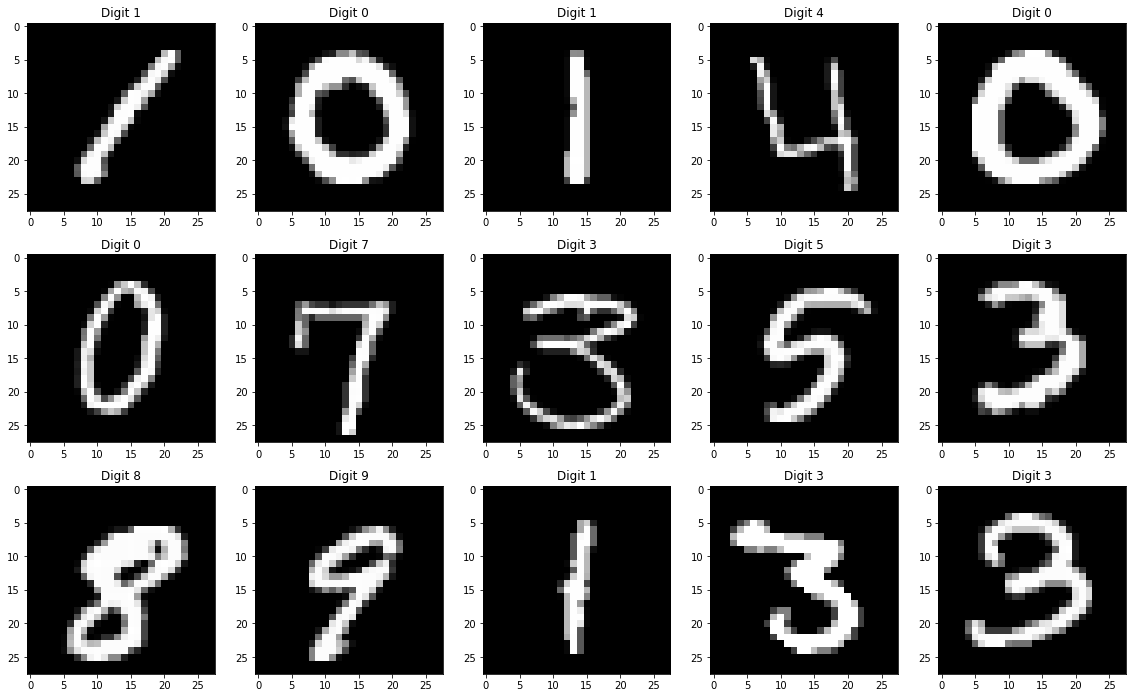

In [4]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))
        
    plt.tight_layout()
    
Show_example_digits()

In [5]:
# Function return digit in grayscale
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'
    
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

7


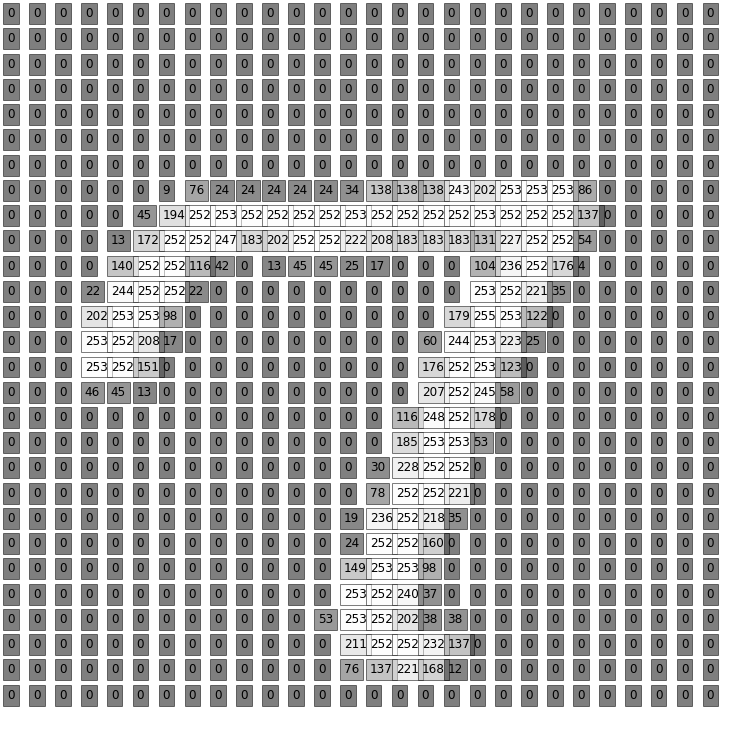

In [6]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

#### Chart of the number of digits in the data

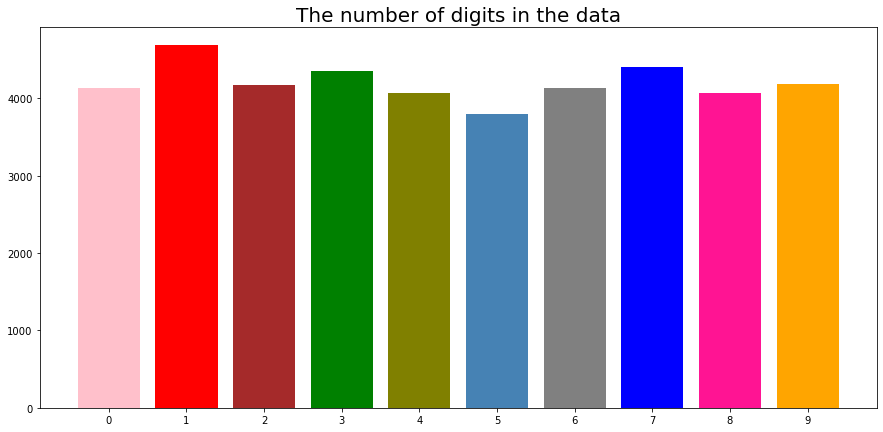

In [7]:
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

## Data Preparing

In [8]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1] 

input_shape = (img_rows, img_cols)

In [9]:
# Data Normalization [0, 1]
X_train /= 255
X_test /= 255

# one-hot encoding for target column
y_train = to_categorical(y_train)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


#### Split data

added stratified folds

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

## MLP ([Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))

### Structure

Firstly, let's think how the network should look like. It will have three layers:

1 Input Layer

2 Hidden Layer

3 Output Layer


![MLP](https://miro.medium.com/max/700/1*-IPQlOd46dlsutIbUq1Zcw.png)

Input layer has 28 * 28 pixels reshape to vector

Hidden layer has a lot of neurons

Output layer has 10 neurons 

Design network with using keras 

The metrics we use are f1_score

In [11]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Function to drawing learning curve history learning neural network



In [12]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

# Adding Callbacks
- EarlyStopping (Stop training when a monitored metric has stopped improving)
- ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)
- ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

In [13]:
def callbacks(name): 
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint(f'../working/{name}.hdf5', save_best_only=True) # saving the best model
    ]

#### Simple MLP with one hidden layer

In [14]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [15]:
model = get_mlp()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Our network has 407,050 params (weights)

#### You can use **GPU** to accelerate training

In [16]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('simple_mlp'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 0s - loss: 0.7187 - f1: 0.7044 - val_loss: 0.3301 - val_f1: 0.9015
Epoch 2/40
37/37 - 0s - loss: 0.2721 - f1: 0.9228 - val_loss: 0.2507 - val_f1: 0.9334
Epoch 3/40
37/37 - 0s - loss: 0.2096 - f1: 0.9415 - val_loss: 0.2057 - val_f1: 0.9424
Epoch 4/40
37/37 - 0s - loss: 0.1714 - f1: 0.9536 - val_loss: 0.1764 - val_f1: 0.9481
Epoch 5/40
37/37 - 0s - loss: 0.1437 - f1: 0.9615 - val_loss: 0.1551 - val_f1: 0.9538
Epoch 6/40
37/37 - 0s - loss: 0.1219 - f1: 0.9669 - val_loss: 0.1387 - val_f1: 0.9568
Epoch 7/40
37/37 - 0s - loss: 0.1063 - f1: 0.9714 - val_loss: 0.1307 - val_f1: 0.9598
Epoch 8/40
37/37 - 0s - loss: 0.0930 - f1: 0.9747 - val_loss: 0.1200 - val_f1: 0.9617
Epoch 9/40
37/37 - 0s - loss: 0.0812 - f1: 0.9793 - val_loss: 0.1154 - val_f1: 0.9635
Epoch 10/40
37/37 - 0s - loss: 0.0713 - f1: 0.9817 - val_loss: 0.1039 - val_f1: 0.9669
Epoch 11/40
37/37 - 0s - loss: 0.0627 - f1: 0.9841 - val_loss: 0.1028 - val_f1: 0.9676
Epoch 12/40
37/37 - 0s - loss: 0.0557 - f1: 0.9863 -

In [17]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.422011882066727%
Test score: 97.54425883293152%
MLP Error: 2.46%


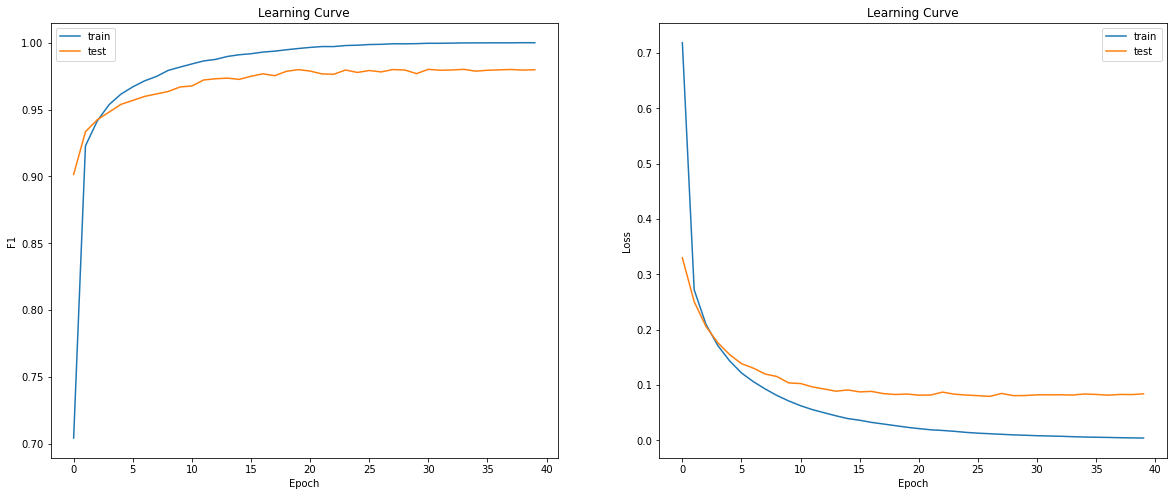

In [18]:
draw_learning_curve(learning_history)

Cool! I get ~98% accuracy with easy model MLP and i didn't work too much.

According to Pareto principle 80/20 in this case 20% work generate ~80%~ 98% accuracy :)

#### Adding new layer and Dropout to avoid overfitting

In [19]:
def get_mlpv2():
    
    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [20]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
________________________________________________

Run new model 

In [21]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 0s - loss: 0.7588 - f1: 0.6870 - val_loss: 0.2606 - val_f1: 0.9216
Epoch 2/40
37/37 - 0s - loss: 0.2448 - f1: 0.9273 - val_loss: 0.1739 - val_f1: 0.9461
Epoch 3/40
37/37 - 0s - loss: 0.1742 - f1: 0.9482 - val_loss: 0.1358 - val_f1: 0.9584
Epoch 4/40
37/37 - 0s - loss: 0.1314 - f1: 0.9611 - val_loss: 0.1100 - val_f1: 0.9662
Epoch 5/40
37/37 - 0s - loss: 0.1062 - f1: 0.9677 - val_loss: 0.0955 - val_f1: 0.9697
Epoch 6/40
37/37 - 0s - loss: 0.0877 - f1: 0.9729 - val_loss: 0.0891 - val_f1: 0.9740
Epoch 7/40
37/37 - 0s - loss: 0.0731 - f1: 0.9772 - val_loss: 0.0834 - val_f1: 0.9738
Epoch 8/40
37/37 - 0s - loss: 0.0612 - f1: 0.9808 - val_loss: 0.0828 - val_f1: 0.9775
Epoch 9/40
37/37 - 0s - loss: 0.0542 - f1: 0.9829 - val_loss: 0.0752 - val_f1: 0.9766
Epoch 10/40
37/37 - 0s - loss: 0.0484 - f1: 0.9846 - val_loss: 0.0728 - val_f1: 0.9789
Epoch 11/40
37/37 - 0s - loss: 0.0424 - f1: 0.9861 - val_loss: 0.0737 - val_f1: 0.9816
Epoch 12/40
37/37 - 0s - loss: 0.0365 - f1: 0.9888 -

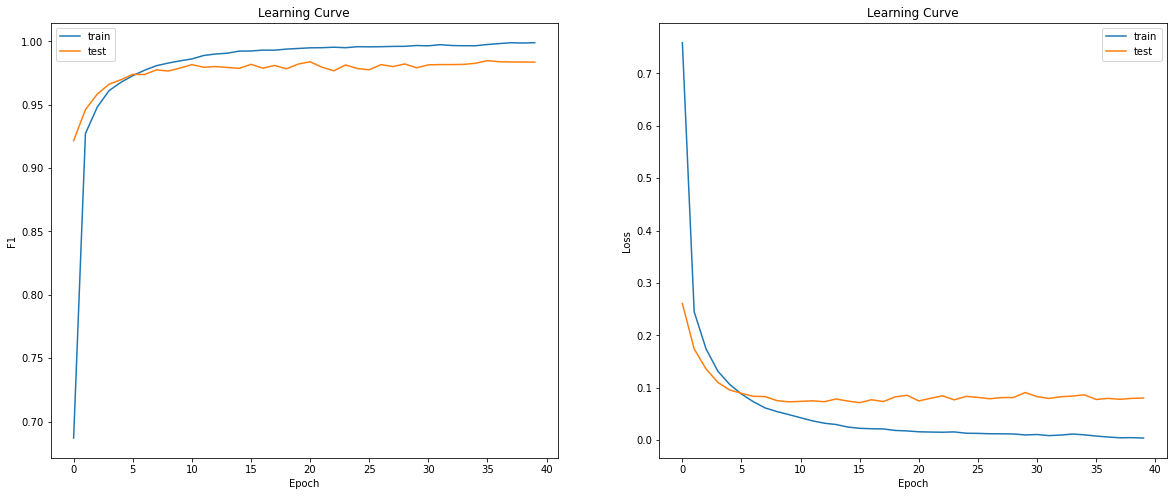

In [22]:
draw_learning_curve(learning_history)

In [23]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.015398681163788%
Test score: 98.22329878807068%
MLP Error: 1.78%


#### I slightly improved the model, so we keep working.

## CNN ([Convolutional_neural_network](https://en.wikipedia.org/wiki/Convolutional_neural_network))

![CNN](https://miro.medium.com/max/1872/1*SGPGG7oeSvVlV5sOSQ2iZw.png)

CNN consists with:
- convolution layer
- in the past MLP

It will use 3 convolutional layers: (Conv2D, Conv2D, pool)

#### We need to reshape data.

In [24]:
X_train.shape

(37800, 784)

In [25]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [26]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [27]:
model = get_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)         

In [28]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

Epoch 1/50
296/296 [==============================] - 2s 8ms/step - loss: 0.5043 - f1: 0.8123 - val_loss: 0.0652 - val_f1: 0.9800
Epoch 2/50
296/296 [==============================] - 2s 7ms/step - loss: 0.1084 - f1: 0.9698 - val_loss: 0.0473 - val_f1: 0.9867
Epoch 3/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0792 - f1: 0.9777 - val_loss: 0.0397 - val_f1: 0.9878
Epoch 4/50
296/296 [==============================] - 2s 8ms/step - loss: 0.0626 - f1: 0.9821 - val_loss: 0.0334 - val_f1: 0.9905
Epoch 5/50
296/296 [==============================] - 2s 8ms/step - loss: 0.0503 - f1: 0.9857 - val_loss: 0.0282 - val_f1: 0.9916
Epoch 6/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0402 - f1: 0.9884 - val_loss: 0.0333 - val_f1: 0.9912
Epoch 7/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0416 - f1: 0.9882 - val_loss: 0.0334 - val_f1: 0.9903
Epoch 8/50
296/296 [==============================] - 2s 7ms/step - loss: 0.0362 - f1: 0.9

In [29]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.042078517377376556
Test score: 0.9932509660720825
CNN Error: 0.67%


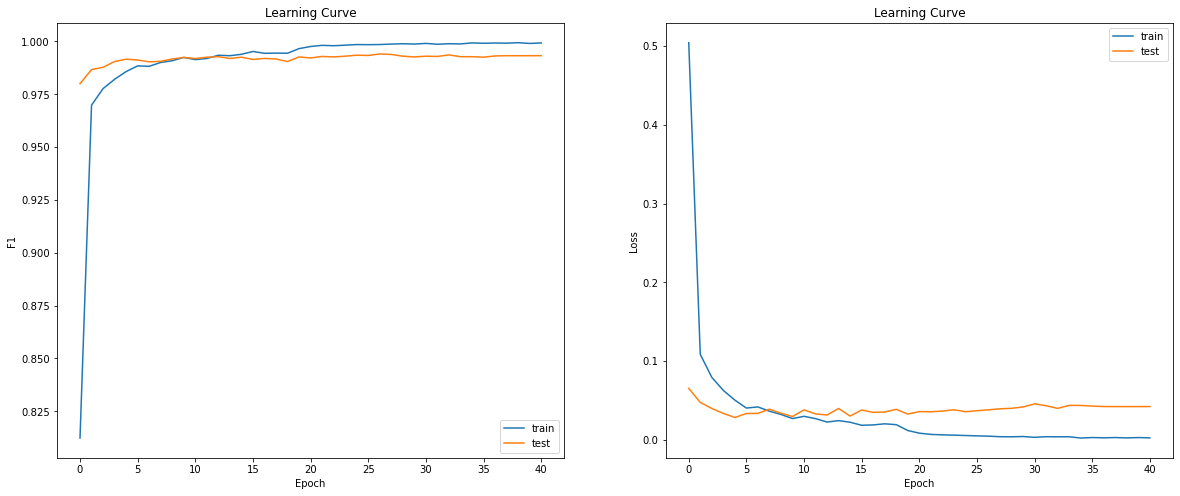

In [30]:
draw_learning_curve(learning_history)

### Let's see in which cases the model is invalid.

#### Let's assign the values provided by the model

In [31]:
y_pred = model.predict(X_val)

#### I made function to visual output

In [32]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = np.ceil(np.sqrt(len(idx_nums)))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]
        
        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10) 
        plt.bar(range(10), y_pred[ph])
        
        cnt += 1

#### The number of errors for the each digit

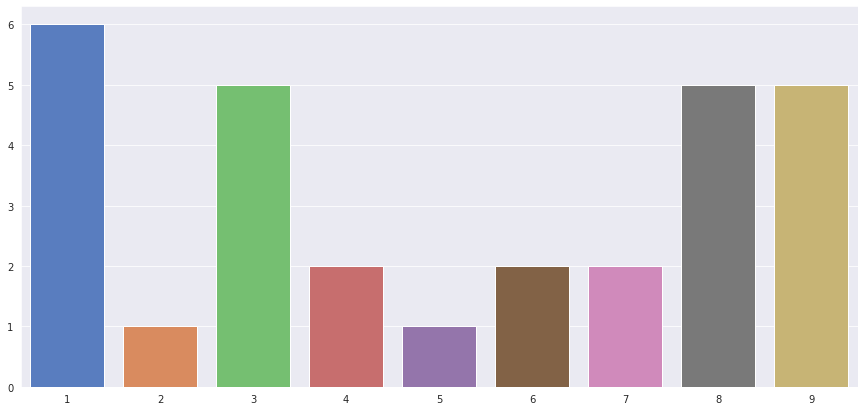

In [33]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    cnt_error.append( (np.argmax(a)) )

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
bar_plot = sns.barplot(cnt_error[0], cnt_error[1], palette="muted")
plt.show()

#### Let's see these photos (2, 9)

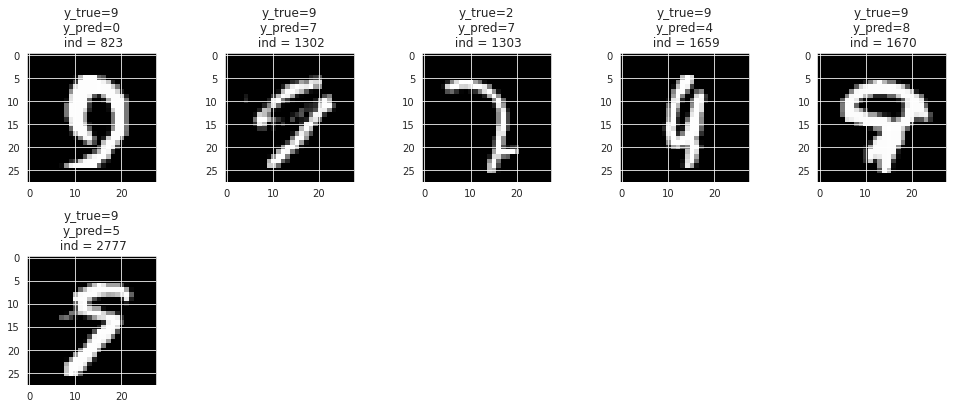

In [34]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 2 or np.argmax(a) == 9):    
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1

#### Run the `draw_output` function to see the probability of each value occurring

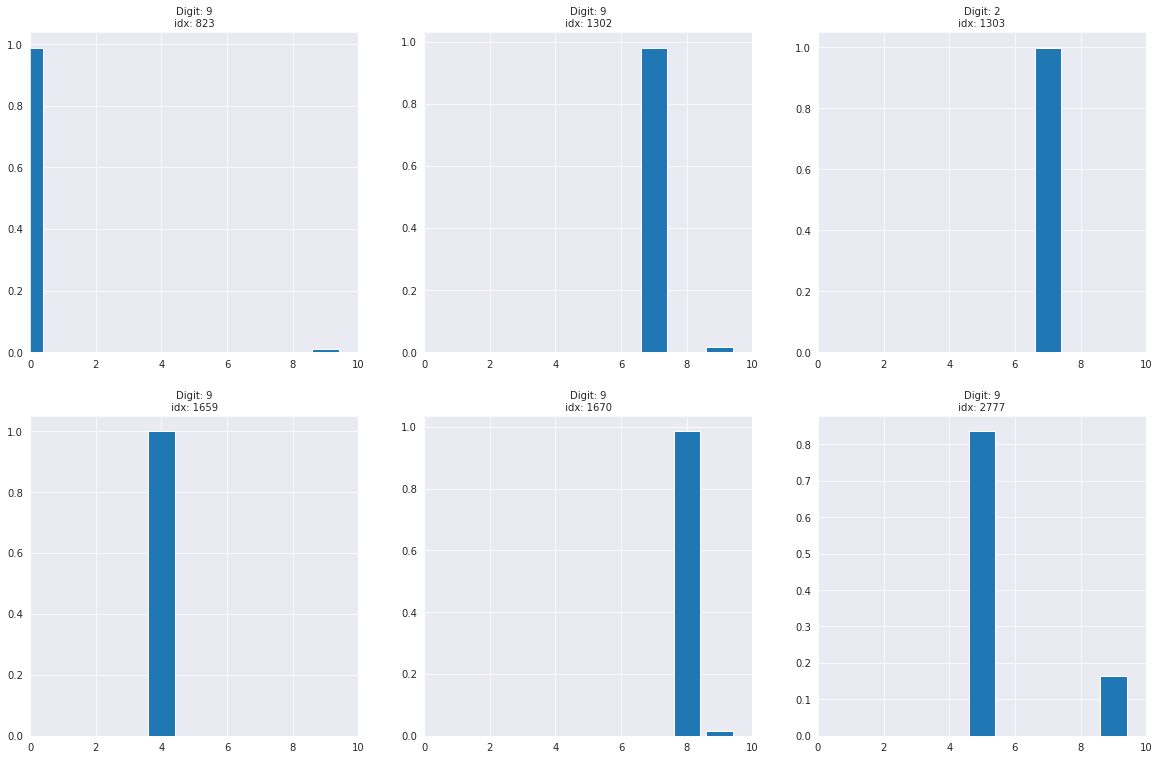

In [35]:
draw_output(list_idx)

#### As you can see, the model is wrong in cases where the common person would also have trouble finding the correct answer.

## Data Augmentation

#### I will try to improve the result by expanding the data. You have to be careful when rotating your photos not to misclassify numbers such as 9 and 6.

#### Data augmentation:

Randomly shift images horizontally by 10% of the width

Randomly shift images vertically by 10% of the height

Randomly rotate images by 10 degrees

Randomly Zoom by 10% some images


In [36]:
train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
        

train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

#### Building new model and using batch normalization

In [37]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
          
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [38]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)       

In [39]:
learning_history = model.fit_generator(train_gen, epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('best_cnn'),
                             )

Epoch 1/100
590/590 [==============================] - 13s 22ms/step - loss: 0.6647 - f1: 0.7753 - val_loss: 0.1414 - val_f1: 0.9588
Epoch 2/100
590/590 [==============================] - 13s 22ms/step - loss: 0.1652 - f1: 0.9521 - val_loss: 0.0701 - val_f1: 0.9783
Epoch 3/100
590/590 [==============================] - 13s 22ms/step - loss: 0.1191 - f1: 0.9660 - val_loss: 0.0532 - val_f1: 0.9830
Epoch 4/100
590/590 [==============================] - 12s 21ms/step - loss: 0.1004 - f1: 0.9724 - val_loss: 0.0450 - val_f1: 0.9885
Epoch 5/100
590/590 [==============================] - 13s 23ms/step - loss: 0.0879 - f1: 0.9758 - val_loss: 0.0642 - val_f1: 0.9832
Epoch 6/100
590/590 [==============================] - 12s 21ms/step - loss: 0.0849 - f1: 0.9761 - val_loss: 0.0553 - val_f1: 0.9848
Epoch 7/100
590/590 [==============================] - 13s 22ms/step - loss: 0.0740 - f1: 0.9784 - val_loss: 0.0370 - val_f1: 0.9882
Epoch 8/100
590/590 [==============================] - 13s 22ms/step 

#### Loading the best model

In [40]:
model = load_model('../working/best_cnn.hdf5', custom_objects={"f1": f1})

In [41]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.0147622749209404
Test score: 0.996091902256012
CNN Error: 0.39%


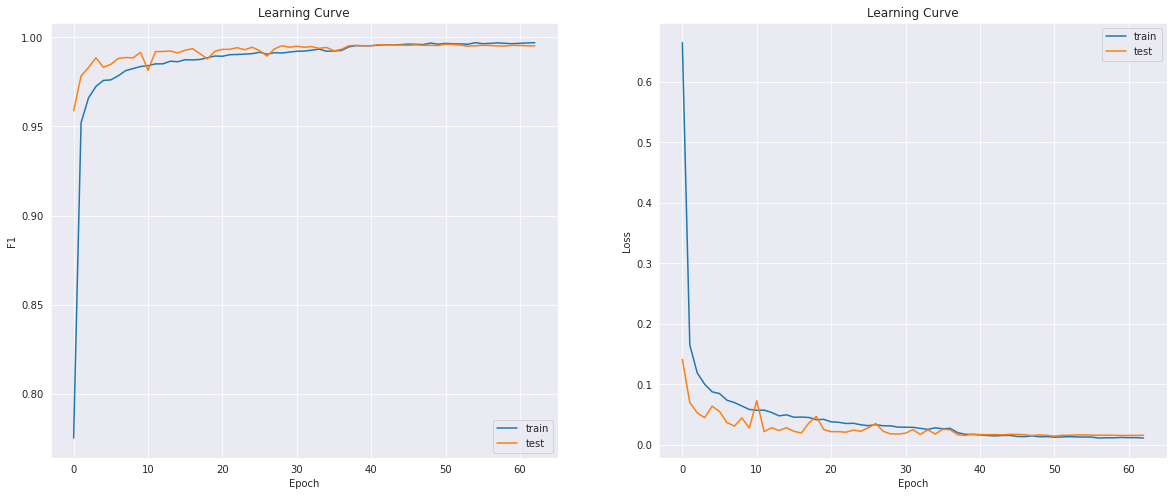

In [42]:
draw_learning_curve(learning_history)

#### We achieved a great result of 99.6% accuracy

# Generate output

In [43]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("submission.csv", index=False)

# Bonus

Let's see, using additional data, how this will affect the final result.

In [44]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train1, y_train1), (x_test1, y_test1) = load_data('../input/mnist-numpy/mnist.npz')

In [45]:
x_train1 = x_train1 / 255
x_test1 = x_test1 / 255

x_train1 = x_train1.reshape(-1, 28, 28, 1)
x_test1 = x_test1.reshape(-1, 28, 28, 1)

y_train1 = y_train1.reshape(y_train1.shape[0], 1)
y_test1 = y_test1.reshape(y_test1.shape[0], 1)

In [46]:
Add_X = np.vstack((x_train1, x_test1))

Add_y = np.vstack((y_train1, y_test1))

Add_y = to_categorical(Add_y)

In [47]:
train = pd.read_csv("../input/digit-recognizer/train.csv")

X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']
y_train = to_categorical(y_train)

X_train /= 255
X_train = X_train.values.reshape(-1, 28, 28, 1)

In [48]:
add_train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
        

add_train_aug.fit(Add_X)
add_train_gen = add_train_aug.flow(Add_X, Add_y, batch_size=64)

In [49]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)       

In [50]:
learning_history = model.fit_generator((add_train_gen), epochs = 100, 
                               steps_per_epoch = x_train1.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('cnn_bonus'),
                             )

Epoch 1/100
937/937 [==============================] - 19s 21ms/step - loss: 0.4899 - f1: 0.8372 - val_loss: 0.0515 - val_f1: 0.9829
Epoch 2/100
937/937 [==============================] - 20s 21ms/step - loss: 0.1352 - f1: 0.9613 - val_loss: 0.0493 - val_f1: 0.9854
Epoch 3/100
937/937 [==============================] - 20s 22ms/step - loss: 0.1004 - f1: 0.9713 - val_loss: 0.0347 - val_f1: 0.9891
Epoch 4/100
937/937 [==============================] - 23s 24ms/step - loss: 0.0801 - f1: 0.9771 - val_loss: 0.0441 - val_f1: 0.9865
Epoch 5/100
937/937 [==============================] - 19s 21ms/step - loss: 0.0737 - f1: 0.9799 - val_loss: 0.0291 - val_f1: 0.9904
Epoch 6/100
937/937 [==============================] - 19s 20ms/step - loss: 0.0648 - f1: 0.9816 - val_loss: 0.0423 - val_f1: 0.9872
Epoch 7/100
937/937 [==============================] - 23s 25ms/step - loss: 0.0634 - f1: 0.9828 - val_loss: 0.0183 - val_f1: 0.9954
Epoch 8/100
937/937 [==============================] - 20s 21ms/step 

In [51]:
model = load_model('cnn_bonus.hdf5', custom_objects={"f1": f1})

In [52]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.001801723730750382
Test score: 0.9995265007019043
CNN Error: 0.05%


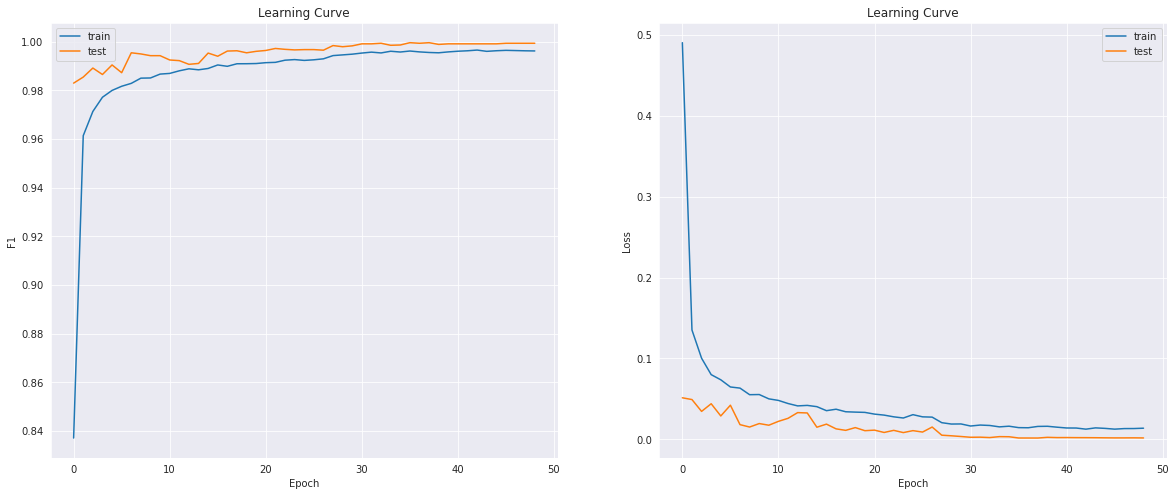

In [53]:
draw_learning_curve(learning_history)

#### As you can see, even with such a large data set, we do not get 100% accuracy

## Visualize Model

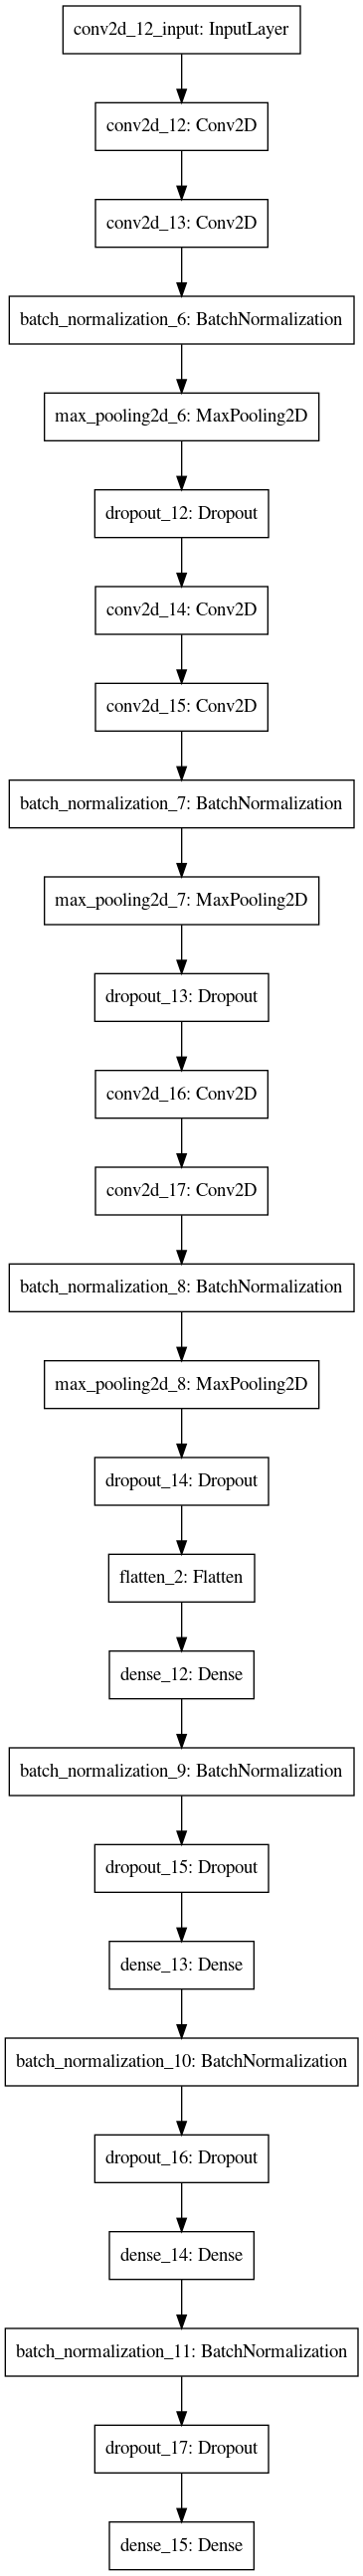

In [54]:
plot_model(model)

# Occlusion sensitivity

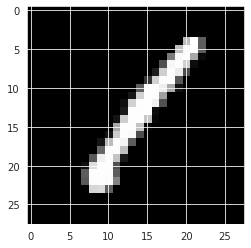

In [55]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray');

In [56]:
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0

    return patched_image


img = X_train[0]

PATCH_SIZE = 4
sensitivity_map = np.zeros((img.shape[0], img.shape[0]))

for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        
        
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[1]
        
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence
        

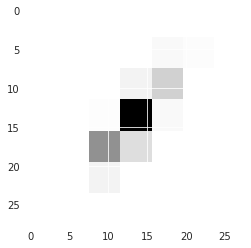

In [57]:
plt.imshow(sensitivity_map, cmap='gray');

# Generate bonus output

In [58]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("bonus_submission.csv", index=False)

### Final step: Conclusions

#### I achieved the following results:
- MLP: ~98% f1
- CNN: ~100% f1

I have created a model that recognizes handwritten numbers. You can try to get more data to make the model even better.


#### This is my first notebook.

#### I would love to know your comments and note about this.

<font size="3">
    <div style="text-align: right"> <b> Author </b> </div>
</font>
<div style="text-align: right"> Jędrzej </div>
<div style="text-align: right"> Dudzicz </div>